In [1]:
pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 72.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 88.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=e13b4c65387728100fbbe79260c10dafe113f09957aa5b3fd4f17cb71c610bee
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=02508acbd849e310abc770382e34f087dca65de6b2d37d36734c320957eefb07
  Sto

(CVXPY) Jun 14 02:53:26 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Jun 14 02:53:26 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.7.0.')


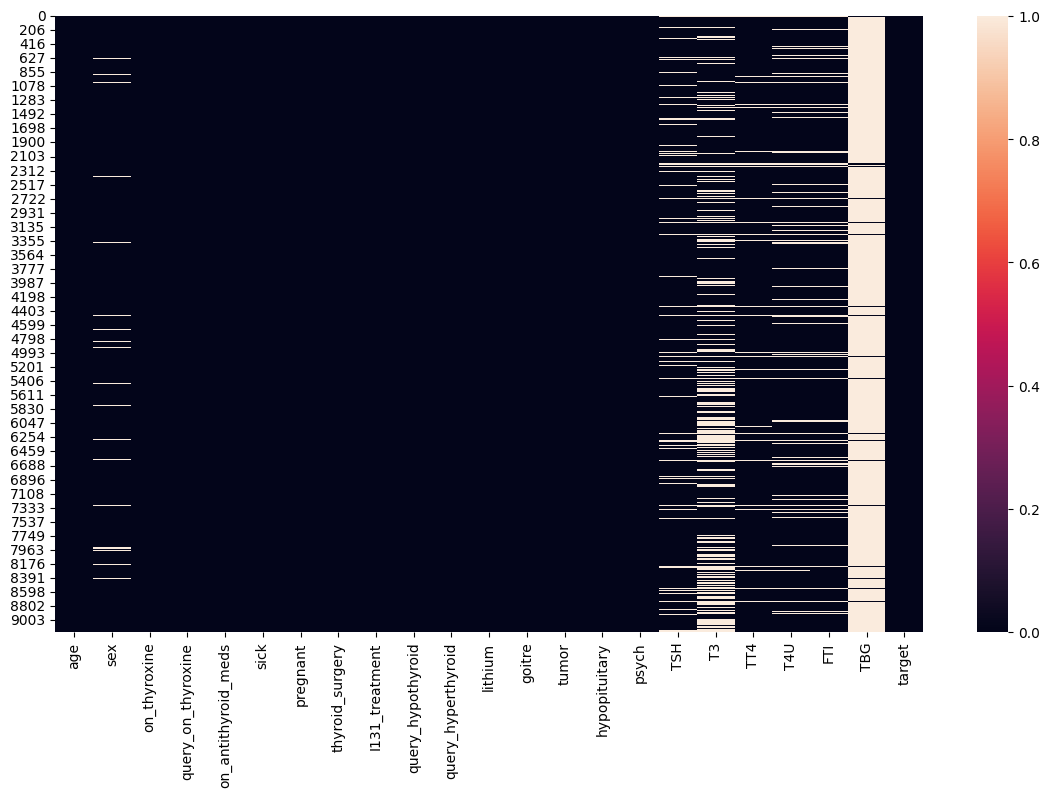

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.figure_factory import create_distplot
from fancyimpute import KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# 1.2 Reading dataset
df = pd.read_csv('/kaggle/input/11dara/thyroidDF.csv')
df.head()

# 1.2 Features Exploration
df.describe().T
df.describe(include='O').T

# 2. Data Cleaning & Handling

# 2.1 Duplicates
df.duplicated().sum()

# 2.2 Feature Cleaning
df.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured', 'referral_source', 'patient_id'], axis=1, inplace=True)

# Target distribution
target_counts = df['target'].value_counts()
fig = px.bar(x=target_counts.index, y=target_counts.values)
fig.update_layout(xaxis_title='Target', yaxis_title='Count', title='Distribution of Target')
fig.show()

# Filtering target classes
df['target'].unique()
df = df[df['target'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'AK', 'C|I', 'H|K', 'GK', 'FK', 'GI', 'GKJ', 'D|R', '-'])]

# Mapping target values
mapping = {'-':"Negative", 'A':'Hyperthyroid','AK':"Hyperthyroid",'B':"Hyperthyroid", 'C':"Hyperthyroid", 'C|I': 'Hyperthyroid', 'D':"Hyperthyroid", 'D|R':"Hyperthyroid",
           'E': "Hypothyroid", 'F': "Hypothyroid", 'FK': "Hypothyroid", "G": "Hypothyroid", "GK": "Hypothyroid", "GI": "Hypothyroid", 'GKJ': 'Hypothyroid', 'H|K': 'Hypothyroid'}
df['target'] = df['target'].map(mapping)

# Target distribution after mapping
target_dist = pd.DataFrame(df['target'].value_counts(), columns=['count'])
fig = px.pie(target_dist, names=target_dist.index, values='count')
fig.update_traces(marker=dict(colors=["#BEE9E9","#6C7B8B", "#3A506B"]))
fig.show()

# 2.3 Outliers
df = df[df['age'] < 100]

# 2.2 Handling Missing Values
plt.subplots(figsize=(14, 8))
sns.heatmap(df.isnull())
plt.show()

null_cols = df.columns[df.isnull().any()]
nulls_df = df.loc[:, null_cols]
nulls_df = pd.DataFrame(nulls_df.isna().sum()/df.shape[0]*100)
nulls_df = nulls_df.rename(columns={0: 'Missing Values %'})
nulls_df

# Dropping TBG feature due to high missing values
df = df.drop('TBG', axis=1)

# Dropping rows with more than 21 missing values
df = df.dropna(thresh=21)



In [ ]:
df.shape

In [3]:
# Filling missing values using KNN Imputer
columns = ['sex', 'age', 'TT4', 'T3', 'T4U', 'FTI', 'TSH']
b_fill_df = df.loc[:, columns]

In [ ]:
df.shape

In [4]:

# Mapping categorical variables
sex_to_num = {'F':0, 'M':1}
b_fill_df['sex'] = b_fill_df['sex'].map(sex_to_num)

knn = KNN(k=13)
knn_imputed_df = knn.fit_transform(b_fill_df)
knn_imputed_df = pd.DataFrame(knn_imputed_df, index=b_fill_df.index, columns=columns)

# Updating the original dataframe with imputed values
df.update(knn_imputed_df)

Imputing row 1/6652 with 1 missing, elapsed time: 7.190
Imputing row 101/6652 with 0 missing, elapsed time: 7.192
Imputing row 201/6652 with 1 missing, elapsed time: 7.193
Imputing row 301/6652 with 1 missing, elapsed time: 7.194
Imputing row 401/6652 with 1 missing, elapsed time: 7.196
Imputing row 501/6652 with 0 missing, elapsed time: 7.197
Imputing row 601/6652 with 1 missing, elapsed time: 7.198
Imputing row 701/6652 with 0 missing, elapsed time: 7.199
Imputing row 801/6652 with 0 missing, elapsed time: 7.200
Imputing row 901/6652 with 1 missing, elapsed time: 7.201
Imputing row 1001/6652 with 0 missing, elapsed time: 7.203
Imputing row 1101/6652 with 0 missing, elapsed time: 7.204
Imputing row 1201/6652 with 1 missing, elapsed time: 7.205
Imputing row 1301/6652 with 0 missing, elapsed time: 7.206
Imputing row 1401/6652 with 0 missing, elapsed time: 7.207
Imputing row 1501/6652 with 0 missing, elapsed time: 7.208
Imputing row 1601/6652 with 0 missing, elapsed time: 7.208
Imputing 

In [ ]:
df.head()

In [ ]:
df.head()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

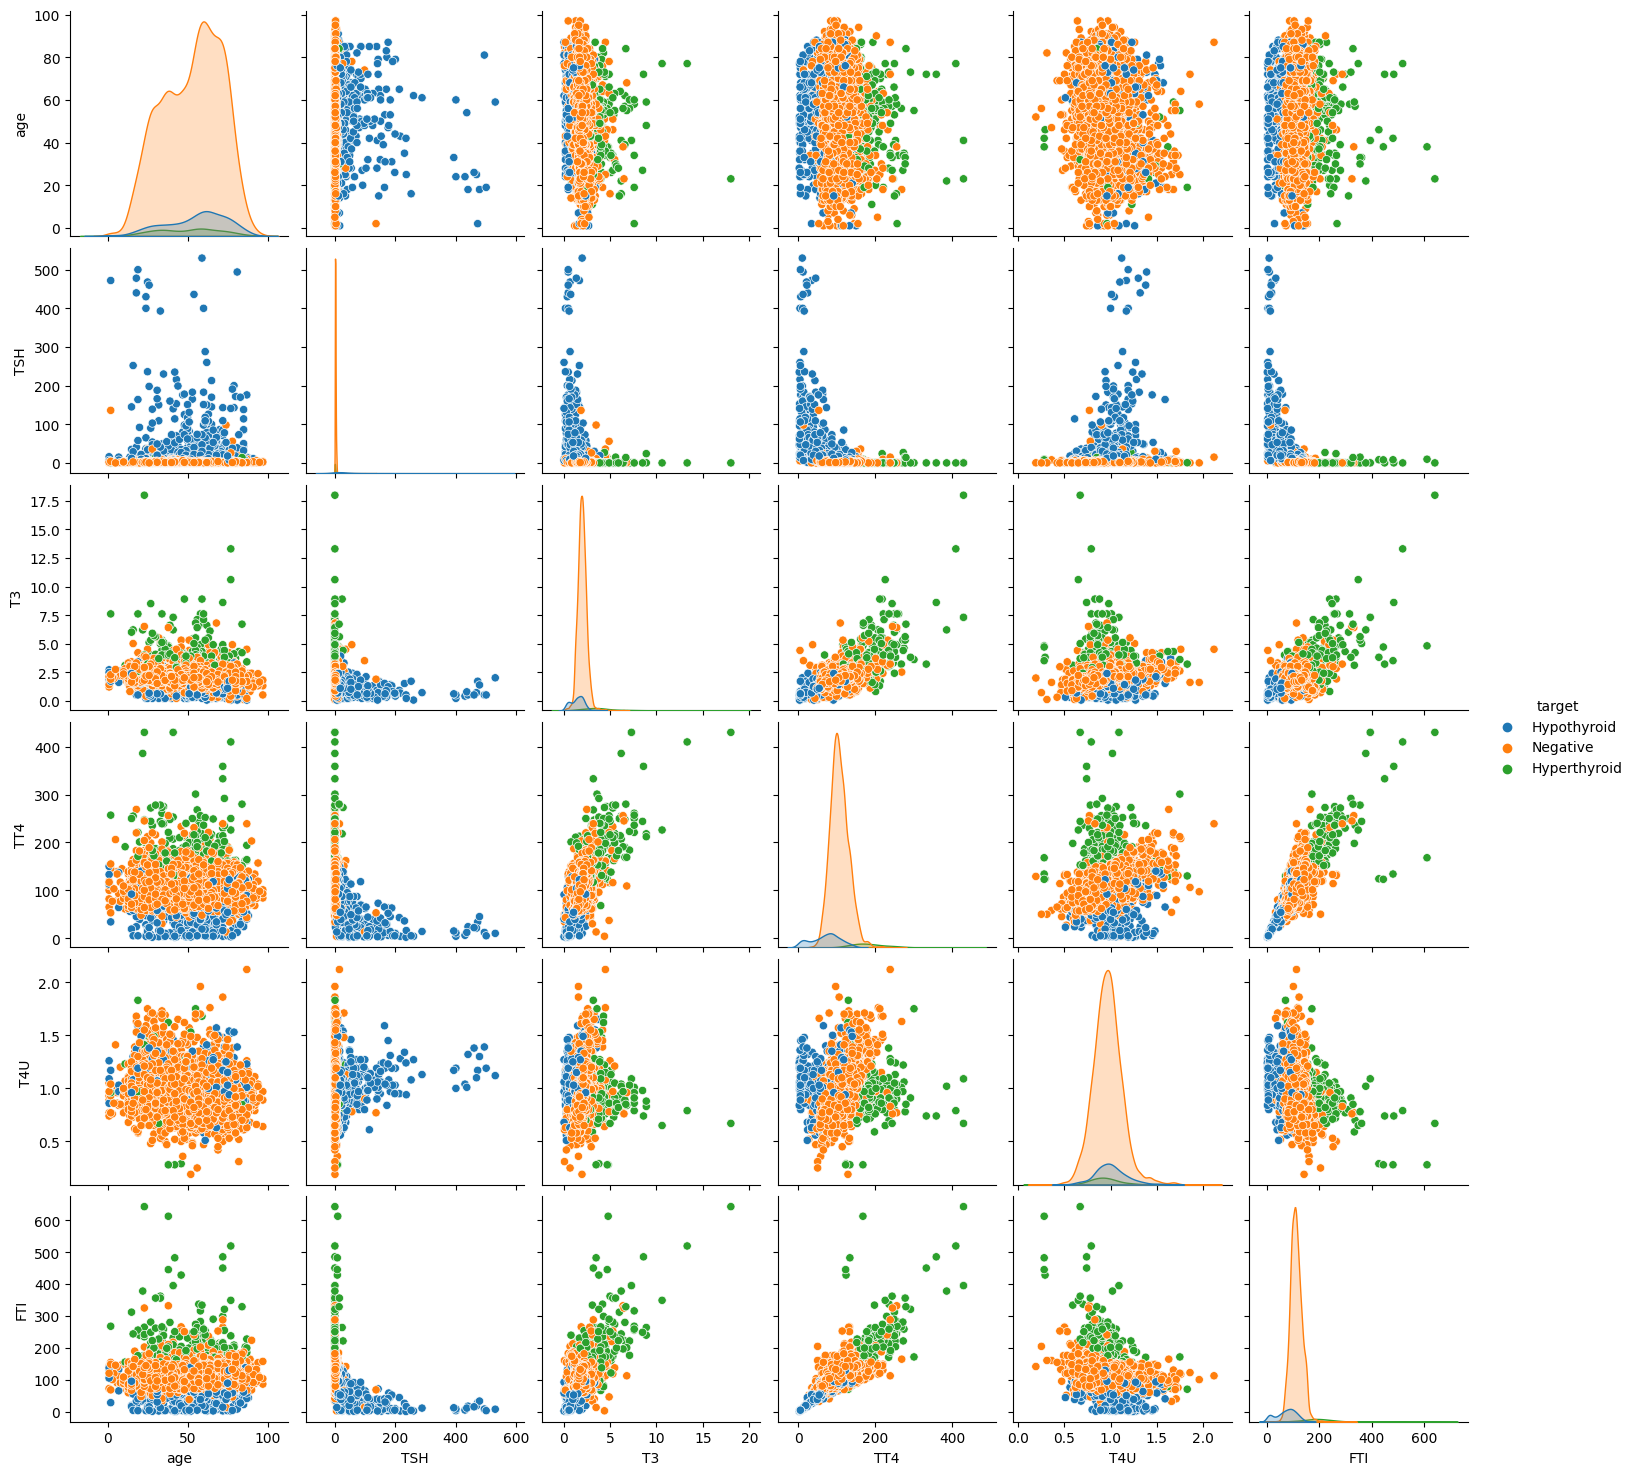

In [5]:
# 3.1 EDA
fig = px.violin(df, x='sex', y='age', color='target', points='all', height=700, color_discrete_map={'Hypothyroid': '#4b9546', 'Hyperthyroid': '#F65366', 'Negative': '#3498db'})
fig.show()

fig = px.histogram(df, x="TSH", color="target", barmode="overlay", color_discrete_map={'Hypothyroid': '#4b9546', 'Hyperthyroid': '#F65366', 'Negative': '#3498db'})
fig.update_layout(title_text='TSH Level by Diagnosis', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.update_xaxes(range= [0,11])
fig.show()

# Pairplot
numerical_df = df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.pairplot(numerical_df, hue='target')

# 4. Modeling
columns = ['age', 'TT4',  'T3', 'T4U', 'FTI', 'TSH', 'pregnant', 'target']
model_df = df.loc[:, columns]

In [ ]:
df.head()

In [ ]:
df.shape

In [6]:
# Encoding categorical variables
model_df['pregnant'] = model_df['pregnant'].replace({'t': 1, 'f': 0})
target_to_num = {'Negative': 0, 'Hypothyroid':1, 'Hyperthyroid':2}
model_df['target'] = model_df['target'].map(target_to_num)

x = model_df.iloc[:, :-1]
y = model_df.iloc[:,-1]



from sklearn.preprocessing import LabelEncoder



/tmp/ipykernel_34/3701171621.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
from tabulate import tabulate
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"Value counts for column '{col}':")
    value_counts = df[col].value_counts()
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [col, 'count']
    print(tabulate(value_counts_df, headers='keys', tablefmt='pretty'))
    print("\n" + "-"*50 + "\n")

In [8]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

In [ ]:
df.head

In [9]:
X = df.drop(["target"],axis=1)
y = df["target"]

In [10]:
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Initialize SMOTE and ENN
smote_enn = SMOTEENN(smote=SMOTE(sampling_strategy='auto'), enn=EditedNearestNeighbours(sampling_strategy='auto'))

# Fit and apply the SMOTE-ENN
x_smot, y_smot = smote_enn.fit_resample(X, y)

In [ ]:
# 4.1 Handling Imbalanced Data with SMOTE
#x_smot, y_smot = SMOTE().fit_resample(X, y)


In [13]:
df.shape

(6652, 22)

In [14]:
# 4.2 Recursive Feature Elimination
rfe_rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rfe_rf, n_features_to_select=16, step=1)
rfe.fit(x_smot, y_smot)
selected_features = X.columns[rfe.support_].tolist()
x_smot_selected = x_smot[selected_features]

<Axes: >

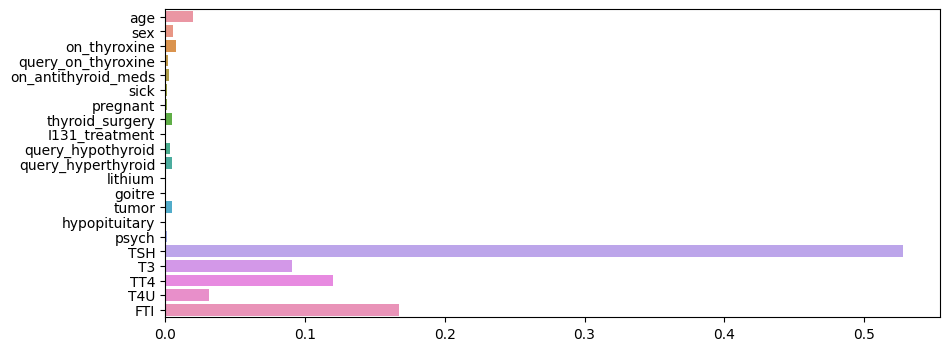

In [15]:
forest = RandomForestClassifier()
forest.fit(X,y)

plt.figure(figsize=(10, 4), dpi = 100)
sns.barplot(y=X.columns, x=forest.feature_importances_)

In [16]:
# Display the selected features
print("Selected features after Recursive Feature Elimination:")
print(selected_features)

Selected features after Recursive Feature Elimination:
['age', 'sex', 'on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'tumor', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']


In [17]:
df.shape

(6652, 22)

In [18]:
x_smot = x_smot[selected_features]

In [ ]:
# PCA for dimension reduction
preserve = 0.9999999
from sklearn.decomposition import PCA
pca = PCA(n_components=preserve)
x_smot_compressed = pca.fit_transform(x_smot)

print(pca.explained_variance_ratio_)

print(f"Reduced dimension from {x_smot.shape[1]} to {x_smot_compressed.shape[1]} preserving {preserve*100}% variance")

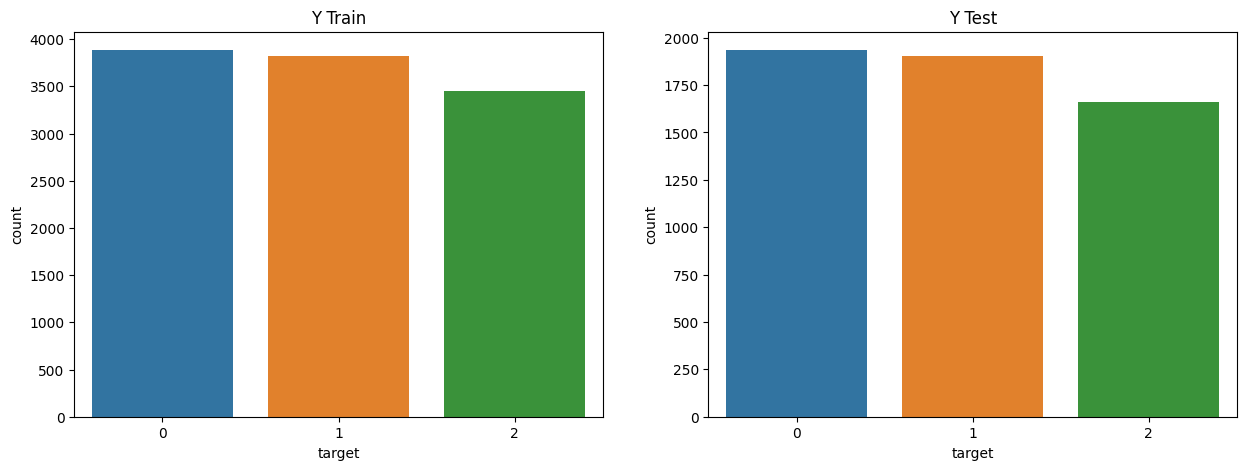

Iteration 1, loss = 2.24231813
Validation score: 0.855864
Iteration 2, loss = 0.34997187
Validation score: 0.888988
Iteration 3, loss = 0.28491821
Validation score: 0.907789
Iteration 4, loss = 0.27576186
Validation score: 0.918532
Iteration 5, loss = 0.22121644
Validation score: 0.937332
Iteration 6, loss = 0.20798392
Validation score: 0.943599
Iteration 7, loss = 0.19383821
Validation score: 0.917637
Iteration 8, loss = 0.22542400
Validation score: 0.910474
Iteration 9, loss = 0.17999252
Validation score: 0.945389
Iteration 10, loss = 0.15630895
Validation score: 0.958818
Iteration 11, loss = 0.15804693
Validation score: 0.960609
Iteration 12, loss = 0.13764689
Validation score: 0.955237
Iteration 13, loss = 0.12945136
Validation score: 0.977619
Iteration 14, loss = 0.12314008
Validation score: 0.954342
Iteration 15, loss = 0.12541744
Validation score: 0.962399
Iteration 16, loss = 0.11061534
Validation score: 0.969561
Iteration 17, loss = 0.09576245
Validation score: 0.980304
Iterat

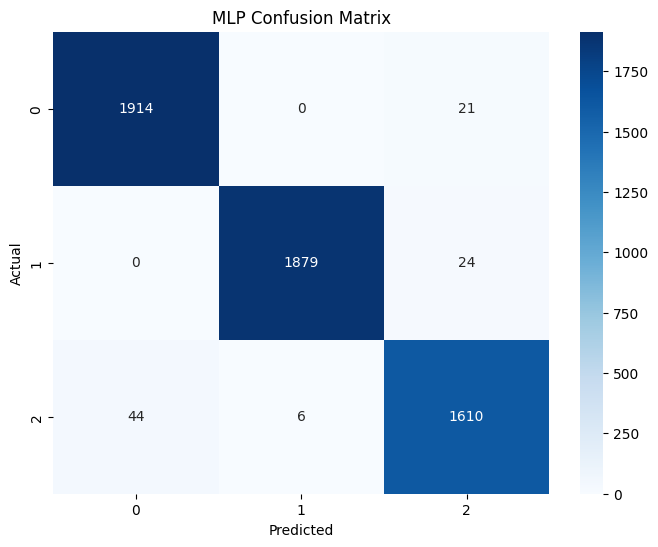

XGBoost Training Accuracy: 1.0
XGBoost Testing Accuracy: 0.9978173881411422
XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1935
           1       1.00      1.00      1.00      1903
           2       1.00      0.99      1.00      1660

    accuracy                           1.00      5498
   macro avg       1.00      1.00      1.00      5498
weighted avg       1.00      1.00      1.00      5498

--------------------------------------------------------------------------------


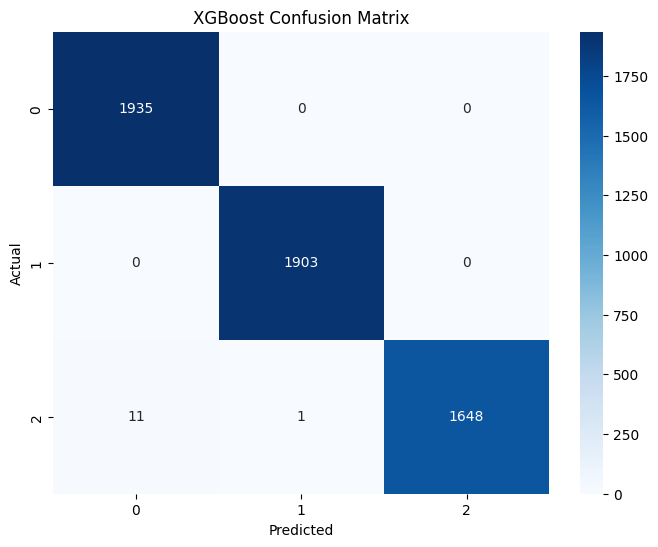

Iteration 1, loss = 2.24231813
Validation score: 0.855864
Iteration 2, loss = 0.34997187
Validation score: 0.888988
Iteration 3, loss = 0.28491821
Validation score: 0.907789
Iteration 4, loss = 0.27576186
Validation score: 0.918532
Iteration 5, loss = 0.22121644
Validation score: 0.937332
Iteration 6, loss = 0.20798392
Validation score: 0.943599
Iteration 7, loss = 0.19383821
Validation score: 0.917637
Iteration 8, loss = 0.22542400
Validation score: 0.910474
Iteration 9, loss = 0.17999252
Validation score: 0.945389
Iteration 10, loss = 0.15630895
Validation score: 0.958818
Iteration 11, loss = 0.15804693
Validation score: 0.960609
Iteration 12, loss = 0.13764689
Validation score: 0.955237
Iteration 13, loss = 0.12945136
Validation score: 0.977619
Iteration 14, loss = 0.12314008
Validation score: 0.954342
Iteration 15, loss = 0.12541744
Validation score: 0.962399
Iteration 16, loss = 0.11061534
Validation score: 0.969561
Iteration 17, loss = 0.09576245
Validation score: 0.980304
Iterat

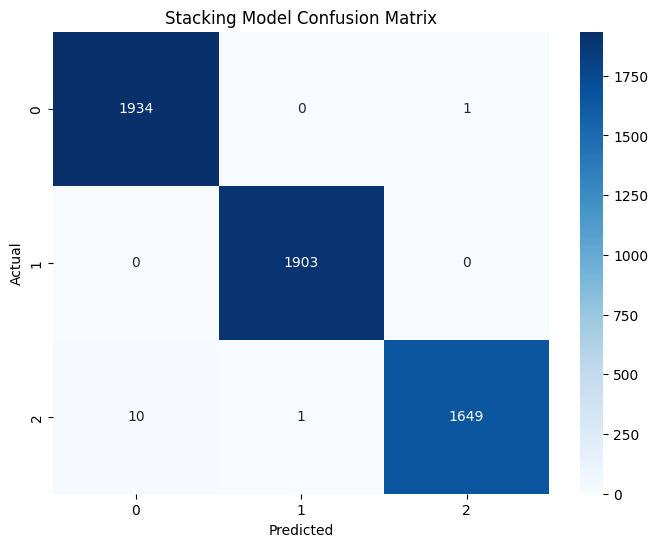

In [19]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 4.3 Data Splitting
x_train, x_test, y_train, y_test = train_test_split(x_smot, y_smot, test_size=0.33, random_state=89)

# Visualize class distribution in train and test sets
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Y Train')
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Y Test')
plt.show()

# 4.4 Models & Hyperparameter Optimization

# Define MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=200, alpha=0.0001,activation='relu',
                     solver='adam', verbose=10,  random_state=21,tol=0.000000001,early_stopping=True)


# Train MLP model
mlp_model.fit(x_train, y_train)

print("MLP Training Accuracy:", mlp_model.score(x_train, y_train))
print("MLP Testing Accuracy:", mlp_model.score(x_test, y_test))

# Evaluate MLP model
mlp_predict = mlp_model.predict(x_test)
print('MLP Classification Report')
print(classification_report(y_test, mlp_predict))
print('-'*80)

# Confusion Matrix for MLP
mlp_con_matrix = confusion_matrix(y_test, mlp_predict)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(mlp_con_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('MLP Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Define XGBoost model
xgb_model = XGBClassifier(max_depth=3)

# Train XGBoost model
xgb_model.fit(x_train, y_train)

print("XGBoost Training Accuracy:", xgb_model.score(x_train, y_train))
print("XGBoost Testing Accuracy:", xgb_model.score(x_test, y_test))

# Evaluate XGBoost model
xgb_predict = xgb_model.predict(x_test)
print('XGBoost Classification Report')
print(classification_report(y_test, xgb_predict))
print('-'*80)

# Confusion Matrix for XGBoost
xgb_con_matrix = confusion_matrix(y_test, xgb_predict)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(xgb_con_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('XGBoost Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Define base models for stacking
base_models = [
    ('mlp', mlp_model),
    ('xgb', xgb_model)
]

# Define meta-model
meta_model = LogisticRegression()

# Define stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=StratifiedKFold(n_splits=5))

# Train stacking model
stacking_model.fit(x_train, y_train)

print("Stacking Model Training Accuracy:", stacking_model.score(x_train, y_train))
print("Stacking Model Testing Accuracy:", stacking_model.score(x_test, y_test))

# Evaluation

# Stacking Model Classification Report
stacking_predict = stacking_model.predict(x_test)
print('Stacking Model Classification Report')
print(classification_report(y_test, stacking_predict))
print('-'*80)

# Confusion Matrix for Stacking Model
con_matrix = confusion_matrix(y_test, stacking_predict)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Stacking Model Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
